In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
import numpy as np
import pubchempy as pcp

In [2]:
ThermoProperties = pd.read_csv('ThermoProperties.csv')
ThermoProperties.tail()

,name,molweight,critical temperature (K),acentric factor,boiling point (K)
6026,water,18.01528,647.13,0.3449,373.15
6027,xylenes,106.16740,620.21,0.3170,413.15
6028,zirconium bromide,410.84000,805.00,0.3100,633.15
6029,zirconium chloride,233.03480,778.00,0.2980,604.15
6030,zirconium iodide,598.84188,960.00,0.3430,704.15


626.32788


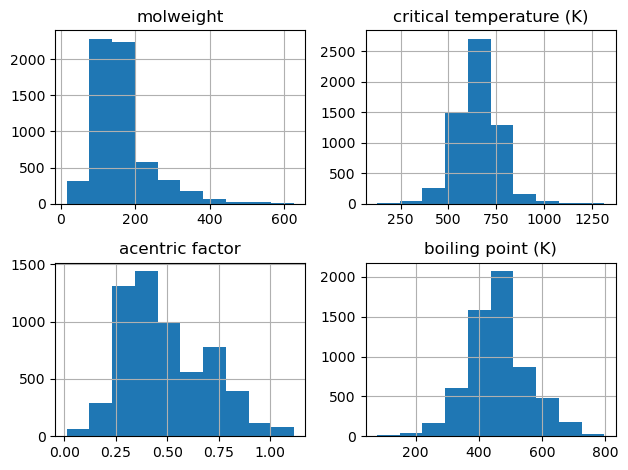

In [3]:
ThermoProperties.hist()
plt.tight_layout()
print(ThermoProperties['molweight'].max())
plt.show()

In [4]:
#yoinking my assignment 5 filter code

#https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy:~:text=versus%20a%20copy-,Warning,even%20before%20pandas%203.0%20is%20available.,-When%20setting%20values
pd.options.mode.copy_on_write = True

#much simplified function which properly handles cases like 1,3-dichloro-2-(chloromethyl)-2-methylpropane
def halocounter(row, suffix):
    name = row['name']
    count=0
    #make a list of prefixes along with their halogen counts
    #note that the only per-compound after removine alkenes and ethers is perfluoroisobutane, which has 10 fluorines.
    prefx = [['per', 10],['deca',10],['nona', 9],['octa', 8],['hepta', 7],['hexa', 6], ['penta', 5], ['tetra', 4], ['tri', 3], ['di', 2], ['', 1]]
    #join the prefixes to the suffixes
    groups = [[name[0] + suffix, name[1]] for name in prefx]
    for group in groups:
        if group[0] in name:
            #multiply halogen count by group count to get total halogens
            #add to running total of halogens
            count += group[1]*name.count(group[0])
            #remove used group name to avoid single halogen group causing double counts
            name = name.replace(group[0],'')
    return count


#if there are no halogens, tag the row for deletion (0)
#otherwise, add them up for a total halogen count
#ugly but it works
def allzero(row):
    if row['Fluorine Containing'] == row['Chlorine Containing'] == row['Bromine Containing'] == row['Iodine Containing'] == 0:
        result = 0
    else:
        result = row['Fluorine Containing'] + row['Chlorine Containing'] + row['Bromine Containing'] + row['Iodine Containing']
    return result

#tag carbon bond type
def aneeneyne(row):
    name = row['name']
    if 'yne' in name:
        result = 3
    elif 'ene' in name:
        result = 2
    elif 'en-' in name:
        result = 2
    elif 'phen' in name:
        result = 2
    elif 'benz' in name:
        result = 2
    elif 'aniline' in name:
        result = 2
    elif 'silane' in name:
        result = 0
    elif 'ether' in name:
        result = 0
    elif 'ester' in name:
        result = 0
    elif 'ane' in name:
        result = 1
    else:
        result = 0
    return result

def singleHalogenifier(row):
    if row['Fluorine Containing']==row['Total Halogens']:
        return '01: Fluorine'
    elif row['Chlorine Containing']==row['Total Halogens']:
        return '02: Chlorine'
    elif row['Bromine Containing']==row['Total Halogens']:
        return '03: Bromine' 
    elif row['Iodine Containing']==row['Total Halogens']:
        return '04: Iodine'
    else:
        return 'None'
    

#making a new dataframe with just halogenated alkanes
AllHalogens = ThermoProperties.copy()
#make new columns for each counts of each halogen as well as carbon bond type
#there is probably a more elegant way to do this
AllHalogens['Fluorine Containing'] = AllHalogens.apply(halocounter, suffix='fluoro', axis=1)
AllHalogens['Chlorine Containing'] = AllHalogens.apply(halocounter, suffix='chloro', axis=1)
AllHalogens['Bromine Containing'] = AllHalogens.apply(halocounter, suffix='bromo', axis=1)
AllHalogens['Iodine Containing'] = AllHalogens.apply(halocounter, suffix='iodo', axis=1)
AllHalogens['bonds'] = AllHalogens.apply(aneeneyne, axis=1)
#make new column for halogen-free deletion tag
AllHalogens['Total Halogens']= AllHalogens.apply(allzero, axis=1)

#select only rows where there is at least one halogen, and where there exist only single bonds
#then reset the index because it bugs me
AllHalogens = AllHalogens[AllHalogens['Total Halogens']>0]
AllHalogens = AllHalogens[AllHalogens['bonds']==1].reset_index()
#looking at first few rows everything seems to have worked


AllHalogens['Contained Halogen'] = AllHalogens.apply(singleHalogenifier, axis=1)
SingleHalogens = AllHalogens[~AllHalogens['Contained Halogen'].str.contains('None')]


#filer data rows are needed due to animation frame limitations
#https://plotly.com/python/animations/#current-animation-limitations-and-caveats
#Animations are designed to work well when each row of input is present across all animation frames, 
#and when categorical values mapped to symbol, color and facet are constant across frames.<----This is a problem for #Halogens (shape)
#Animations may be misleading or inconsistent if these constraints are not met.
def makefillerdict(species):
    num_halogens = [1, 2, 3, 4, 5, 6, 7, 8,10]
    filler = pd.DataFrame({'Total Halogens':num_halogens,
                 'molweight':[-100]*len(num_halogens),
                 'critical temperature (K)':[400]*len(num_halogens),
                 'acentric factor':[0.4]*len(num_halogens),
                 'boiling point (K)':[400]*len(num_halogens),
                 'Contained Halogen':[species]*len(num_halogens)})
    return filler
    

filler_fluorine = makefillerdict("01: Fluorine")
filler_chlorine = makefillerdict("02: Chlorine")
filler_bromine = makefillerdict("03: Bromine")
filler_iodine = makefillerdict("04: Iodine")
SingleHalogens = pd.concat([SingleHalogens, filler_fluorine, filler_chlorine, filler_bromine, filler_iodine])

#sort then strip numbering to make it pretty
SingleHalogens = SingleHalogens.sort_values(by=['Contained Halogen', 'Total Halogens']) #have to sort to get legend in the right order
#strip first four characters from the beginning of the Contained Halogen string ("#: ")
SingleHalogens['Contained Halogen'] = SingleHalogens['Contained Halogen'].str[4:]

#for some reason, custom markers can only be used with string inputs
#so I need to convert the number of halogens to a string here.

def stringifier(row):
    return str(row['Total Halogens'])

SingleHalogens['Total Halogens'] = SingleHalogens.apply(stringifier, axis=1)

In [5]:
#"Good" Figure: Represents data in a consistent manner across all attributes
#Pleasing to the eye
#Uses colorscale which is not cyclical and does not fade out at one end or in the middle
#hover data is named properly
#axes and scales are consistent across all data
#does not try to display too much data at once.
#filtering with slider allows for easy comparison


custom_markers={'1': 'circle', '2': 'square', '3': 'diamond', '4':'cross', '5':'x', '6':'triangle-up', '7':'triangle-down', '8':'triangle-left', '10':'triangle-right'}
label_dict = {'molweight': 'Molecular Weight (g/mol)','critical temperature (K)': 'Critical Temperature (K)','boiling point (K)':'Boiling Point (K)',
                'acentric factor': 'Acentric Factor','name':'Species'}


fig = px.scatter(SingleHalogens, x='molweight', y='boiling point (K)', 
                 color = 'critical temperature (K)', color_continuous_scale='viridis', 
                 size='acentric factor', template='plotly_dark',
                 hover_name = 'name', animation_frame='Contained Halogen', symbol='Total Halogens',
                 symbol_map = custom_markers,
                 labels = label_dict,
                 title = 'Properties of Homogeneous Haloalkanes')
fig.update_xaxes(range=[0, 600])
fig.update_yaxes(range=[150, 1000])
fig.update_layout(legend = dict(bgcolor = 'teal'))
fig.update_layout(coloraxis_colorbar_orientation='h')
fig["layout"].pop("updatemenus")
fig.show()
fig.write_html("goodfig.html")

In [6]:
Titanic = pd.read_csv('titanic.csv')
Titanic.head()

,Survived,Pclass,Name,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare
0,0,3,Mr. Owen Harris Braund,male,22.0,1,0,7.2500
1,1,1,Mrs. John Bradley (Florence Briggs Thayer) Cum...,female,38.0,1,0,71.2833
2,1,3,Miss. Laina Heikkinen,female,26.0,0,0,7.9250
3,1,1,Mrs. Jacques Heath (Lily May Peel) Futrelle,female,35.0,1,0,53.1000
4,0,3,Mr. William Henry Allen,male,35.0,0,0,8.0500


In [7]:
fig = px.density_heatmap(Titanic, x='Name', y='Fare', z = 'Survived', animation_frame='Age', color_continuous_scale='Edge')
fig["layout"].pop("updatemenus")
fig.show()

In [8]:
Titanic2 = Titanic.copy().sample(500)
#Titanic2['Survived'] = Titanic2['Survived']+1
#px.bar_polar(Titanic2, r='Fare', theta='Survived', color='Name', color_continuous_scale='Edge')
fig = px.scatter(Titanic2, x='Survived', y='Sex', color='Fare', color_continuous_scale='Edge', hover_name='Name', hover_data = 'Pclass')
#fig.update_yaxes(range=[8000, 8500])
fig.show()

(0.13, 0.97)

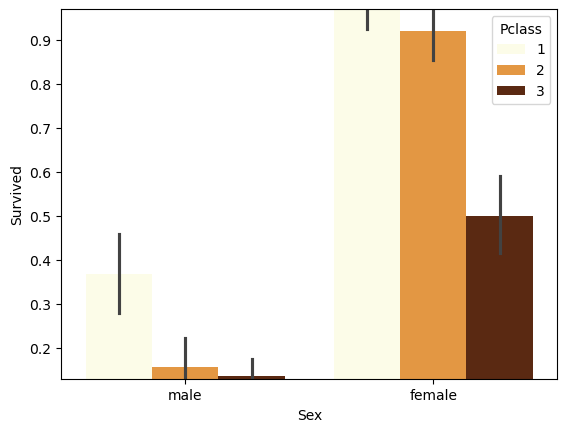

In [9]:
#dumb_palette = sns.color_palette('YlOr', as_cmap=True)
fig = sns.barplot(Titanic, x='Sex', y='Survived', hue='Pclass', palette='YlOrBr')
fig.set_ylim([0.13, 0.97])

In [10]:
toilets = pd.read_csv('toiletmap_aus.csv')
toilets = toilets[~toilets['AddressNote'].isna()]


In [11]:
#contains 19 equally spaced points between 00 and ff such that ffff## goes from nearly pure yellow to white.
reallybadcolorsequence = ['#ffff00', '#ffff0e', '#ffff1c', '#ffff2a', '#ffff39', '#ffff47', '#ffff55', '#ffff63', '#ffff71', '#ffff80', '#ffff8e', '#ffff9c',
                          '#ffffaa', '#ffffb8', '#ffffc6', '#ffffd4', '#ffffe3', '#fffff1', '#ffffff'] 
fig = px.scatter_geo(toilets, lat='Latitude', lon='Longitude', color='FacilityType', color_discrete_sequence=reallybadcolorsequence,
                    center = {'lat':toilets['Latitude'].mean(), 'lon':toilets['Longitude'].mean()}, 
                    hover_name = 'Name', hover_data = 'AddressNote')#,animation_frame='Name',)
fig.update_layout(dragmode=False)
fig.update_traces(marker={'size': 30})
#fig.layout.updatemenus[0].buttons[0].args[1]['frame']['duration'] = 5
#fig.layout.updatemenus[0].buttons[0].args[1]['transition']['duration'] = 1
#fig["layout"].pop("updatemenus")
fig.show(config={ 'modeBarButtonsToRemove': ['zoom', 'pan'] })


In [12]:
#contains 19 equally spaced points between 00 and ff such that ffff## goes from nearly pure yellow to white.
reallybadcolorsequence = ['#ffff00', '#ffff0e', '#ffff1c', '#ffff2a', '#ffff39', '#ffff47', '#ffff55', '#ffff63', '#ffff71', '#ffff80', '#ffff8e', '#ffff9c',
                          '#ffffaa', '#ffffb8', '#ffffc6', '#ffffd4', '#ffffe3', '#fffff1', '#ffffff'] 
fig = px.scatter(toilets, x='Latitude', y='Longitude', color='FacilityType', color_discrete_sequence=reallybadcolorsequence, 
                    hover_name = 'Name', hover_data = 'AddressNote', opacity=1, symbol='FacilityID')#,animation_frame='Name',)
fig.update_layout(dragmode=False)
fig.update_traces(marker={'size': 50})
#fig.layout.updatemenus[0].buttons[0].args[1]['frame']['duration'] = 5
#fig.layout.updatemenus[0].buttons[0].args[1]['transition']['duration'] = 1
#fig["layout"].pop("updatemenus")
fig.show(config={ 'modeBarButtonsToRemove': ['zoom', 'pan'] })
fig.write_html("badfig.html")